In [8]:
import pandas as pd
train_df = pd.read_parquet('../data/yellow_tripdata_2023-01.parquet')
for c in ['tpep_dropoff_datetime', 'tpep_pickup_datetime']:
    train_df[c] = pd.to_datetime(train_df[c])
train_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


In [9]:
# compute duration
train_df['duration'] = (train_df['tpep_dropoff_datetime']- train_df['tpep_pickup_datetime']).dt.total_seconds()/60
train_df['duration'].describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

In [10]:
# drop outliers
is_inlier = train_df['duration'].between(1,60,inclusive='both')
print(is_inlier.mean())
train_df = train_df[is_inlier] 

0.9812202822125979


In [18]:
# dict vectorizer
from sklearn.preprocessing import OneHotEncoder

pred_cols = ['PULocationID', 'DOLocationID']
ohe = OneHotEncoder(handle_unknown='infrequent_if_exist')
X_train = ohe.fit_transform(train_df[pred_cols])
X_train.shape


(3009173, 515)

/home/sos00/projects/mlops-zoomcamp/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 7.649262440990083


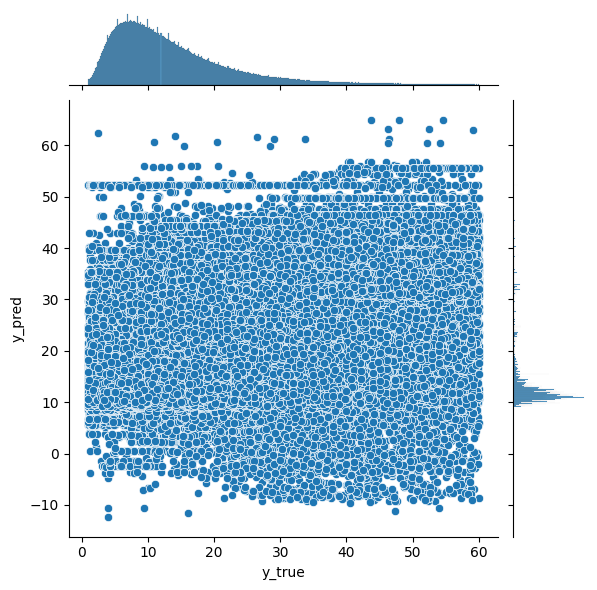

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



y = train_df['duration']
lr = LinearRegression()
lr.fit(X = X_train, y=y)
y_pred = lr.predict(X_train)
print('RMSE:', mean_squared_error(y, y_pred, squared=False))
pl = sns.jointplot(pd.DataFrame(dict(y_true=y, y_pred=y_pred)), x='y_true', y='y_pred')
plt.show()


In [19]:
del X_train # free memory

In [20]:
def preprocess_data(fp):
    """
    function to read and preprocess data
    """
    df = pd.read_parquet(fp)
    for c in ['tpep_dropoff_datetime', 'tpep_pickup_datetime']:
        df[c] = pd.to_datetime(df[c])
    df['duration'] = (df['tpep_dropoff_datetime']- df['tpep_pickup_datetime']).dt.total_seconds()/60
    is_inlier = df['duration'].between(1, 60, inclusive='both')
    print(f'Dropping {1- is_inlier.mean():.2f}% outliers')
    df = df[is_inlier]
    return df

df = preprocess_data('../data/yellow_tripdata_2023-02.parquet')
y_test = df['duration']
X_test = ohe.transform(df[pred_cols])

print(mean_squared_error(y_test, lr.predict(X_test), squared=False))

Dropping 0.02% outliers
7.811811212153113


/home/sos00/projects/mlops-zoomcamp/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
